In [1]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

import matplotlib.pyplot as plt

# Input View
#
#  CREATE VIEW DATAIKU_ANALYTICS_SUB.DATA_SCIENCE.NAFCUSTOMER_REVENUE_AGGREGATED
#  AS
#  SELECT
#  CUSTOMER_ID,
#  CUSTOMER,
#  YEAR(REVENUE_DATE) as REVENUE_YEAR,
#  MONTH(REVENUE_DATE) as REVENUE_MONTH,
#  MIN(SETUP_DATE) AS SETUP_DATE,
#  MIN(BI_CUS_PAR) as BI_CUS_PAR,
#  MIN(BI_PRODUCT) as BI_PRODUCT,
#  MIN(BI_MRU) as BI_MRU,
#  SUM(REVENUE_AMOUNT_USD) as REVENUE_AMOUNT_USD,
#  SUM(GROSS_SPEND_AMOUNT) as GROSS_SPEND_AMOUNT,
#  SUM(PURCHASE_GALLONS_QTY) PURCHASE_GALLONS_QTY,
#  SUM(TOTAL_ACTIVE_CARD_COUNT) as TOTAL_ACTIVE_CARD_COUNT
#  FROM DATAIKU_ANALYTICS_SUB.DATA_SCIENCE.NAFCUSTOMER_REVENUE
#  WHERE (FUNDED_BY IS NULL OR FUNDED_BY='Unknown' OR FUNDED_BY='WEX Funded')
#  AND (NOT((REVENUE_CODE='26') AND (CUSTOMER_ID IS NULL)))
#  AND (NOT((REVENUE_CODE='E8') AND (CUSTOMER_ID IS NULL)))
#  GROUP BY 1,2,3,4


from datetime import date, datetime, timedelta
import time

t0 = time.time()

# Read recipe inputs
NAFCUSTOMER_REVENUE_AGGREGATED = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED")
NAFCUSTOMER_REVENUE_AGGREGATED_df = NAFCUSTOMER_REVENUE_AGGREGATED.get_dataframe()

t1 = time.time()
print("load duration", (t1-t0)/60.0, "minutes")

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df))
NAFCUSTOMER_REVENUE_AGGREGATED_df.head()

load duration 6.04992569287618 minutes
18075044


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,SETUP_DATE,BI_CUS_PAR,BI_PRODUCT,BI_MRU,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT
0,77487332.0,REA ACCOUNTING,2022,7,2021-08-27 07:00:00+00:00,11200.0,15308.0,4000.0,17.79,244.32,32.319,2.0
1,77276079.0,HELPING OUT PEOPLE ENVIRONMENTS LLC,2022,12,2011-07-22 07:00:00+00:00,32600.0,15100.0,4120.0,32.51,2330.82,850.612,2.0
2,77626898.0,WALLEY TRACTOR SERVICE,2022,6,2021-09-21 07:00:00+00:00,53000.0,10100.0,4120.0,43.63,1861.50,319.709,2.0
3,77188826.0,DORR TRUCK SALES LLC,2020,11,2012-12-17 08:00:00+00:00,13000.0,15100.0,4000.0,0.00,0.00,0.000,0.0
4,77604036.0,TROPICAL GREENERY INC,2019,6,2006-02-28 08:00:00+00:00,10500.0,10100.0,3100.0,46.10,1457.48,602.707,15.0


In [64]:
print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df))
df = NAFCUSTOMER_REVENUE_AGGREGATED_df

18075044


In [65]:
# cast year as integer, create a revenue date column at the monthly grain
df['CUSTOMER_ID'] = df['CUSTOMER_ID'].astype('Int64')
df['SETUP_DATE_DT'] = pd.to_datetime(df['SETUP_DATE'])

df['REVENUE_YEAR'] = df['REVENUE_YEAR'].astype('Int64')
df['REVENUE_DATE'] = df['REVENUE_MONTH'].astype(str) + '-' + df['REVENUE_YEAR'].astype(str)
df['REVENUE_DATE'] = pd.to_datetime(df['REVENUE_DATE'], format='%m-%Y').dt.strftime('%m-%Y')

print(len(df))
df = df[df.REVENUE_YEAR!=2023]
print(len(df))

18075044
17673397
17673363


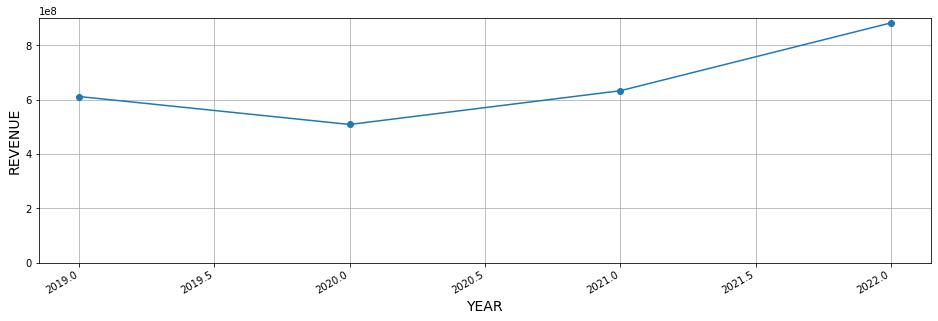

,REVENUE_YEAR,REVENUE_AMOUNT_USD
0,2019,6.118864e+08
1,2020,5.089370e+08
2,2021,6.331482e+08
3,2022,8.830073e+08


In [66]:
import matplotlib.dates as mdates

# aggregate revenue at annual grain
df_revenue_per_year = df.groupby(['REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()

# plot out 
fig, ax1 = plt.subplots(figsize=(16,5))
ax1.plot(df_revenue_per_year['REVENUE_YEAR'],df_revenue_per_year['REVENUE_AMOUNT_USD'], marker='o')
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('REVENUE', fontsize=14)
ax1.grid()
ax1.set_ylim(ymin=0)
fig.autofmt_xdate()
#ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.show()

df_revenue_per_year.head()

In [74]:
df_customer_monthly_card_count = df.groupby(['CUSTOMER_ID','REVENUE_DATE']).TOTAL_ACTIVE_CARD_COUNT.sum().reset_index()
df_customer_monthly_card_count.head()

,CUSTOMER_ID,REVENUE_DATE,TOTAL_ACTIVE_CARD_COUNT
0,77000000,01-2019,0.0
1,77000000,02-2019,0.0
2,77000000,03-2019,0.0
3,77000001,05-2022,1.0
4,77000001,06-2022,1.0


In [75]:
df_customer_max_monthly_card_sum = df.groupby(['CUSTOMER_ID']).TOTAL_ACTIVE_CARD_COUNT.max().reset_index()
df_customer_max_monthly_card_sum['CUSTOMER_FLEET_SIZE'] = 'NOT SET'
df_customer_max_monthly_card_sum.loc[df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]>1700,'CUSTOMER_FLEET_SIZE'] = "XL (>1700 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]>115)&(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]<=1700),'CUSTOMER_FLEET_SIZE'] = "L (>115 and <=1700 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]>21)&(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]<=115),'CUSTOMER_FLEET_SIZE'] = "M (>21 and <=115 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]<=21),'CUSTOMER_FLEET_SIZE'] = "S (<=21 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]==0),'CUSTOMER_FLEET_SIZE'] = "No Cards"
df_customer_max_monthly_card_sum.loc[df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"].isnull(),'CUSTOMER_FLEET_SIZE'] = "No Cards"

df_customer_max_monthly_card_sum.CUSTOMER_FLEET_SIZE.value_counts(dropna=False)

S (<=21 Cards)               521977
No Cards                      80904
M (>21 and <=115 Cards)       40936
L (>115 and <=1700 Cards)      6735
XL (>1700 Cards)                334
Name: CUSTOMER_FLEET_SIZE, dtype: int64

In [76]:
df_customer_max_monthly_card_sum.head()

,CUSTOMER_ID,TOTAL_ACTIVE_CARD_COUNT,CUSTOMER_FLEET_SIZE
0,77000000,0.0,No Cards
1,77000001,2.0,S (<=21 Cards)
2,77000002,3.0,S (<=21 Cards)
3,77000003,21.0,S (<=21 Cards)
4,77000004,2.0,S (<=21 Cards)


In [79]:
# aggregate customers at min setup date
df_customer_min_setup = df.groupby(['CUSTOMER_ID']).SETUP_DATE.min().reset_index()
df_customer_min_setup.columns = ['CUSTOMER_ID','MIN_SETUP_DATE']
df_customer_min_setup['CUSTOMER_ID'] = df_customer_min_setup['CUSTOMER_ID'].astype('Int64')

df_customer_min_setup.head()

650886
650886


,CUSTOMER_ID,MIN_SETUP_DATE
0,77000000,2012-10-29 07:00:00+00:00
1,77000001,2022-04-12 07:00:00+00:00
2,77000002,2018-10-25 07:00:00+00:00
3,77000003,2022-06-08 07:00:00+00:00
4,77000004,2018-08-20 07:00:00+00:00


In [80]:
df_customer_min_setup.CUSTOMER_ID.value_counts(dropna=False)

77205570    1
77615114    1
77600771    1
77602820    1
77604869    1
           ..
77615094    1
77102832    1
77635564    1
77639658    1
NaN         0
Name: CUSTOMER_ID, Length: 650887, dtype: Int64

In [84]:
print(len(df))
df_j = pd.merge(df, df_customer_min_setup, on='CUSTOMER_ID', how='inner')
print(len(df_j))

df_j = pd.merge(df_j, df_customer_max_monthly_card_sum, on='CUSTOMER_ID', how='inner')
print(len(df_j))

df_j.head()

17673363
17673363
17673363


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,SETUP_DATE,BI_CUS_PAR,BI_PRODUCT,BI_MRU,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT_x,REVENUE_DATE,SETUP_DATE_DT,MIN_SETUP_DATE,TOTAL_ACTIVE_CARD_COUNT_y,CUSTOMER_FLEET_SIZE
0,77487332,REA ACCOUNTING,2022,7,2021-08-27 07:00:00+00:00,11200.0,15308.0,4000.0,17.79,244.32,32.319,2.0,07-2022,2021-08-27 07:00:00+00:00,2018-12-04 08:00:00+00:00,2.0,S (<=21 Cards)
1,77487332,REA ACCOUNTING,2021,10,2021-08-27 07:00:00+00:00,11200.0,15308.0,4000.0,12.81,162.57,13.699,1.0,10-2021,2021-08-27 07:00:00+00:00,2018-12-04 08:00:00+00:00,2.0,S (<=21 Cards)
2,77487332,REA ACCOUNTING,2020,9,2018-12-04 08:00:00+00:00,11200.0,15100.0,4000.0,67.00,55.99,14.738,1.0,09-2020,2018-12-04 08:00:00+00:00,2018-12-04 08:00:00+00:00,2.0,S (<=21 Cards)
3,77487332,REA ACCOUNTING,2022,11,2021-08-27 07:00:00+00:00,11200.0,15308.0,4000.0,-140.26,466.11,86.513,2.0,11-2022,2021-08-27 07:00:00+00:00,2018-12-04 08:00:00+00:00,2.0,S (<=21 Cards)
4,77487332,REA ACCOUNTING,2022,9,2021-08-27 07:00:00+00:00,11200.0,15308.0,4000.0,187.59,844.83,142.551,2.0,09-2022,2021-08-27 07:00:00+00:00,2018-12-04 08:00:00+00:00,2.0,S (<=21 Cards)


In [85]:
print(len(df_j))
# retain only those customers that already existed before the analysis period
df_j = df_j[df_j.MIN_SETUP_DATE.dt.year<2019]
print(len(df_j))
df_j.head()

17673363
13581403


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,SETUP_DATE,BI_CUS_PAR,BI_PRODUCT,BI_MRU,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT_x,REVENUE_DATE,SETUP_DATE_DT,MIN_SETUP_DATE,TOTAL_ACTIVE_CARD_COUNT_y,CUSTOMER_FLEET_SIZE
0,77487332,REA ACCOUNTING,2022,7,2021-08-27 07:00:00+00:00,11200.0,15308.0,4000.0,17.79,244.32,32.319,2.0,07-2022,2021-08-27 07:00:00+00:00,2018-12-04 08:00:00+00:00,2.0,S (<=21 Cards)
1,77487332,REA ACCOUNTING,2021,10,2021-08-27 07:00:00+00:00,11200.0,15308.0,4000.0,12.81,162.57,13.699,1.0,10-2021,2021-08-27 07:00:00+00:00,2018-12-04 08:00:00+00:00,2.0,S (<=21 Cards)
2,77487332,REA ACCOUNTING,2020,9,2018-12-04 08:00:00+00:00,11200.0,15100.0,4000.0,67.00,55.99,14.738,1.0,09-2020,2018-12-04 08:00:00+00:00,2018-12-04 08:00:00+00:00,2.0,S (<=21 Cards)
3,77487332,REA ACCOUNTING,2022,11,2021-08-27 07:00:00+00:00,11200.0,15308.0,4000.0,-140.26,466.11,86.513,2.0,11-2022,2021-08-27 07:00:00+00:00,2018-12-04 08:00:00+00:00,2.0,S (<=21 Cards)
4,77487332,REA ACCOUNTING,2022,9,2021-08-27 07:00:00+00:00,11200.0,15308.0,4000.0,187.59,844.83,142.551,2.0,09-2022,2021-08-27 07:00:00+00:00,2018-12-04 08:00:00+00:00,2.0,S (<=21 Cards)


4 customer records


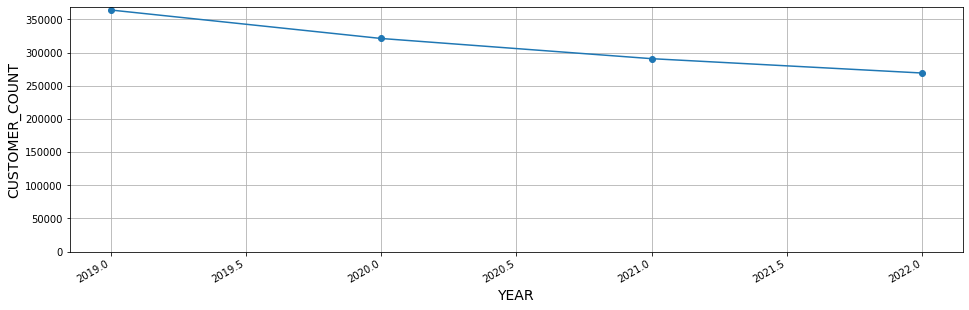

,REVENUE_YEAR,CUSTOMER_COUNT
0,2019,364138
1,2020,321219
2,2021,290783
3,2022,269153


In [81]:
df_customer_count = df_j.groupby(['REVENUE_YEAR']).CUSTOMER_ID.nunique().reset_index()
df_customer_count.columns = ['REVENUE_YEAR','CUSTOMER_COUNT']
print(len(df_customer_count), 'customer records')

# plot out 
fig, ax1 = plt.subplots(figsize=(16,5))
ax1.plot(df_customer_count['REVENUE_YEAR'],df_customer_count['CUSTOMER_COUNT'], marker='o')
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('CUSTOMER_COUNT', fontsize=14)
ax1.grid()
ax1.set_ylim(ymin=0)
fig.autofmt_xdate()
#ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.show()

df_customer_count.head()

13581403
11641


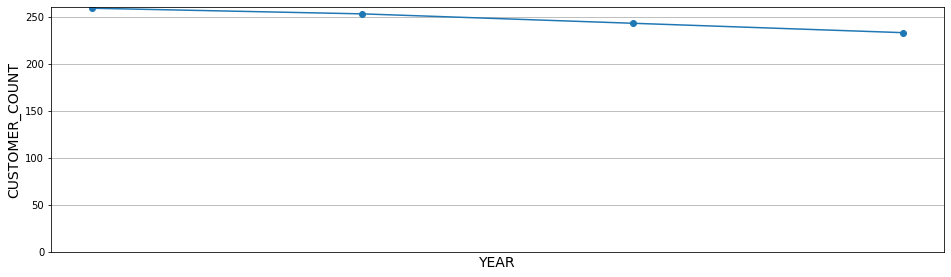

In [97]:
#S (<=21 Cards)
#No Cards
#M (>21 and <=115 Cards)
#L (>115 and <=1700 Cards)
#XL (>1700 Cards)

print(len(df_j))
df_XL = df_j[df_j.CUSTOMER_FLEET_SIZE=='XL (>1700 Cards)']
print(len(df_XL))

max_y = df_XL.CUSTOMER_COUNT.max()
max_y = max_y + max_y*0.10

df_XL = df_XL.groupby(['REVENUE_YEAR']).CUSTOMER_ID.nunique().reset_index()
df_XL.columns = ['REVENUE_YEAR','CUSTOMER_COUNT']
df_XL.head()

# plot out 
fig, ax1 = plt.subplots(figsize=(16,5))
ax1.plot(df_XL['REVENUE_YEAR'],df_XL['CUSTOMER_COUNT'], marker='o')
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('CUSTOMER_COUNT', fontsize=14)
ax1.grid()
ax1.set_ylim(ymin=0)
fig.autofmt_xdate()
ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.show()

259

In [0]:
# Compute recipe outputs from inputs
# TODO: Replace this part by your actual code that computes the output, as a Pandas dataframe
# NB: DSS also supports other kinds of APIs for reading and writing data. Please see doc.

#TENURE_CALC_df = NAFCUSTOMER_REVENUE_AGGREGATED_df # For this sample code, simply copy input to output


# Write recipe outputs
#TENURE_CALC = dataiku.Dataset("TENURE_CALC")
#TENURE_CALC.write_with_schema(TENURE_CALC_df)